Percentage of divorced with deposit=1: 48.11%
Percentage of single with deposit=1: 54.35%
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each 

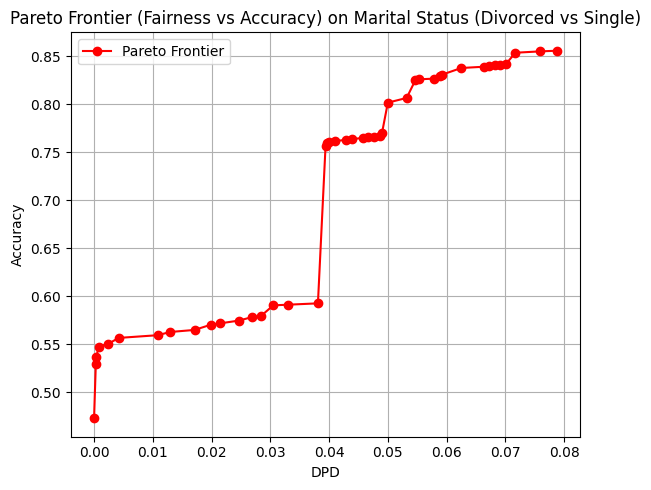

✅ Strict Pareto frontier points: 44


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from skopt.space import Integer
import matplotlib.pyplot as plt

# --- STEP 1: Load and Preprocess Data ---
df = pd.read_csv("/kaggle/input/bank-marketing-dataset/bank.csv")
df = df.dropna()

# Convert target to binary
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# Filter to only 'single' and 'divorced' for fairness comparison
df = df[df['marital'].isin(['single', 'divorced'])].copy()

# --- STEP 1.5: EDA ---
divorced_yes = df[(df['marital'] == 'divorced') & (df['deposit'] == 1)].shape[0]
divorced_total = df[df['marital'] == 'divorced'].shape[0]
single_yes = df[(df['marital'] == 'single') & (df['deposit'] == 1)].shape[0]
single_total = df[df['marital'] == 'single'].shape[0]
print(f"Percentage of divorced with deposit=1: {100 * divorced_yes / divorced_total:.2f}%")
print(f"Percentage of single with deposit=1: {100 * single_yes / single_total:.2f}%")

# Encode categorical variables
df = pd.get_dummies(df, columns=['job', 'education', 'contact', 'month', 'poutcome'], drop_first=True)
binary_map = {'yes': 1, 'no': 0}
for col in ['default', 'housing', 'loan']:
    df[col] = df[col].map(binary_map)

# Encode marital column (for fairness)
df['marital'] = df['marital'].map({'divorced': 1, 'single': 0})

X = df.drop(columns=['deposit'])
y = df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=50)
marital_test = X_test['marital'].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 2: Fairness Metric ---
def compute_dpd(y_pred, marital):
    p_divorced = y_pred[marital == 1].mean()
    p_single = y_pred[marital == 0].mean()
    return abs(p_divorced - p_single)

# --- STEP 3: Bayesian Optimization ---
search_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10)
}
opt = BayesSearchCV(
    RandomForestClassifier(random_state=50),
    search_spaces=search_space,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
opt.fit(X_train_scaled, y_train)
best_model = opt.best_estimator_

# --- STEP 4: Evaluate (Threshold, Alpha) Grid ---
alphas = np.linspace(0.0, 1.0, 50)
thresholds = np.linspace(0.01, 0.99, 1000)
probas = best_model.predict_proba(X_test_scaled)[:, 1]

results = []
for alpha in alphas:
    for thresh in thresholds:
        preds = (probas >= thresh).astype(int)
        acc = accuracy_score(y_test, preds)
        dpd = compute_dpd(preds, marital_test)
        obj = alpha * dpd + (1 - alpha) * (1 - acc)
        results.append((dpd, acc, obj, alpha, thresh))

results_df = pd.DataFrame(results, columns=['DPD', 'Accuracy', 'Objective', 'Alpha', 'Threshold'])

# --- STEP 5: Strict Pareto Frontier Filtering (non-dominated points only) ---
def pareto_frontier(points):
    pareto = []
    for i, (dpd_i, acc_i) in enumerate(points):
        dominated = False
        for j, (dpd_j, acc_j) in enumerate(points):
            if i != j:
                if (acc_j >= acc_i and dpd_j <= dpd_i) and (acc_j > acc_i or dpd_j < dpd_i):
                    dominated = True
                    break
        if not dominated:
            pareto.append((dpd_i, acc_i))
    return np.array(pareto)

# Unique points by rounding
results_df[['DPD', 'Accuracy']] = results_df[['DPD', 'Accuracy']].round(4)
unique_points = results_df[['DPD', 'Accuracy']].drop_duplicates().values.tolist()
approx_frontier = pareto_frontier(unique_points)

# --- STEP 6: Plot Only Pareto Frontier ---
plt.figure(figsize=(6, 5))
approx_frontier = approx_frontier[np.argsort(approx_frontier[:, 0])]  # sort by DPD
plt.plot(approx_frontier[:, 0], approx_frontier[:, 1], 'r-o', label='Pareto Frontier')
plt.xlabel('DPD')
plt.ylabel('Accuracy')
plt.title('Pareto Frontier (Fairness vs Accuracy) on Marital Status (Divorced vs Single)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Strict Pareto frontier points: {len(approx_frontier)}")